In [1]:
import sys
import numpy as np
from astropy import units as u
from astropy.constants import c as c_light_speed
import matplotlib.pyplot as plt
from sedfitter.sed import SEDCube
import pystellibs

In [2]:
sys.path.append('dev/')
from dev.data import PhotData
from dev.star_cluster import StarCluster
from dev.parsec_isochrones import Parsec
# from dev.evolution_tracks_parsec import EvoTrackPARSEC
from dev.base import PhotometryPipeline
from dev.disk_properties import CondDiskProperties
from dev.yso import YSO
from dev.spectral_interpolator import SpectrumGenerator

parsec_folder_path = '/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/isochrone_files/gaia_phot'
parsec_file_path = '/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1/parsec_tracks_postprocessed.csv'
base_path_yso = '/Users/ratzenboe/Documents/work/data_local/spectal_models/yso_models/models_richardson24/'

In [4]:
star_cluster_kwargs = dict(
    mu=np.array([100, 0, 0, 10, 10, 10]),
    cov=np.diag([10, 10, 10, 1, 1, 1]),
    cluster_mass=1e3,
    logAge=6.0,
    Z=0.0125
)

phpipe = PhotometryPipeline(steps=[
    ('cluster', StarCluster(**star_cluster_kwargs)),
    # ('parsec_isochrones', EvoTrackPARSEC(parsec_file_path)),
    ('parsec_isochrones', Parsec(parsec_folder_path)),
    ('disk_prop', CondDiskProperties()),
    ('yso_model', YSO(base_dir=base_path_yso, yso_models='all')),
    ('spectrum', SpectrumGenerator(stellib=pystellibs.BaSeL())),
])

PARSEC isochrones read and processed!
Loading YSO models, this might take a few seconds to minutes...
Loading SPUBHMI model...
SPUBHMI model loaded.
Loading SP-H-I model...
SP--H-I model loaded.
Loading S---MI model...
S---MI model loaded.
Loading SP-HMI model...
SP-HMI model loaded.


In [5]:
data = PhotData()

phpipe.set_params(
    cluster__mu=np.array([1000, 0, 0, 10, 10, 10]),    # <-- update cluster center
    cluster__logAge=5.7,
    # spectrum__stellib=pystellibs.BTSettl(),             # <-- update stellar library models
    # dustmap__dustmap='planck',                        # <-- use Planck dustmap
)
data = phpipe.run(data)
data.aperture_arcsec = 3*np.ones(data.N) * u.arcsec

Total cluster mass is 998.59 (limit was 1000)
































Processing spubhmi for 942 sources
Processing s---smi for 117 sources
Processing sp--h-i for 75 sources
Processing sp--hmi for 552 sources
Generating spectra for 1701 sources (out of 2557)


In [6]:
data.aperture_arcsec.to(u.arcsec)

<Quantity [3., 3., 3., ..., 3., 3., 3.] arcsec>

Text(0, 0.5, 'Flux [erg/s/cm2/AA]')

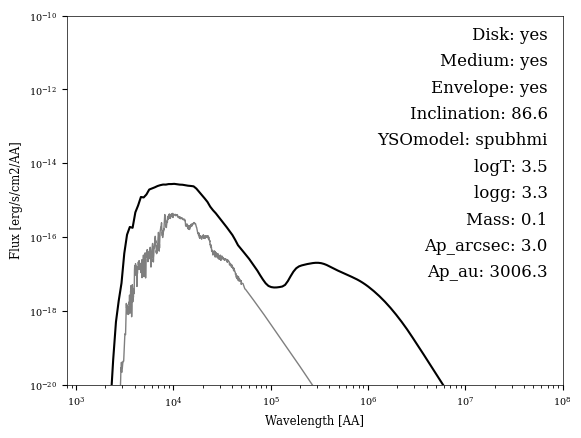

In [7]:
idx = 1202
components = dict(
    Disk = data.has_disk[idx]==1.,
    # DiskMass = data.logDiskMass[idx],
    Medium = data.has_ambient_medium[idx]==1.,
    Envelope = data.has_envelope[idx]==1.,
    Inclination = data.incl[idx],
    YSOmodel = data.model_used[idx],
    logT = data.logT[idx],
    logg = data.logg[idx],
    Mass = data.mass[idx],
    Ap_arcsec = data.aperture_arcsec[idx].value,
    Ap_au = data.aperture[idx].value,
)
plt.loglog(data.wavelength_yso, data.flam_yso[idx], 'k-', alpha=1)
plt.loglog(data.wavelength, data.flam[idx], 'k-', alpha=0.5, lw=1)

for i, (desc, val) in enumerate(components.items()):
    if isinstance(val, np.bool_):
        has_val = "yes" if val else "no"
    elif isinstance(val, (int, float)):
        has_val = f"{val:.1f}"
    else:
        has_val = val
    # Put the text at the center of the plot
    plt.annotate(
        f"{desc}: {has_val}",
        xy=(0.97, 0.97 - i/14),  # Center of the plot
        xycoords="axes fraction",
        ha="right",
        va="top",
        fontsize=12,
        # bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )

plt.xlim(800, 1e8)
plt.ylim(1e-20, 1e-10)
plt.xlabel('Wavelength [AA]')
plt.ylabel('Flux [erg/s/cm2/AA]')

In [12]:
data.flam_yso is None

True

In [24]:
f_all = np.full(shape=(df.shape[0], 20, 200), fill_value=np.nan) * u.erg / u.s / u.cm**2 / u.AA
f_all[matches_model] = out[0]

(2237, 20, 200)

In [496]:
from scipy.interpolate import interp1d

In [520]:
ip = interp1d(yso_model.sed_cube.apertures.value, fl.T, bounds_error=False, fill_value='extrapolate')

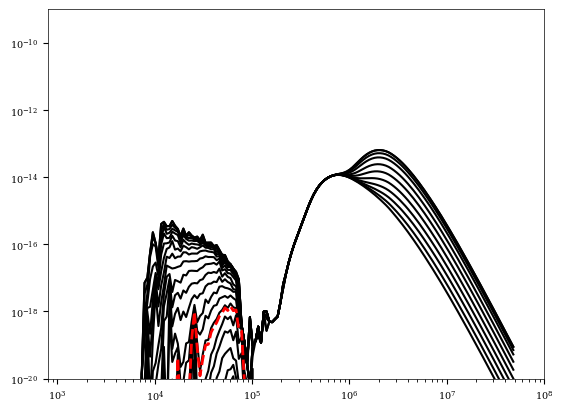

In [542]:
plt.loglog(wave, fl.T, 'k-', alpha=1)
plt.xlim(800, 1e8)
plt.ylim(1e-20, 1e-9)

plt.loglog(wave, ip(yso_model.sed_cube.apertures.value.max()), 'r--', alpha=1, lw=2)

In [ ]:
plt.loglog(wave.value, fluxes[0].T, 'k-', alpha=1)
plt.xlim(800, 1e8)
plt.ylim(1e-20, 1e-9)

In [ ]:
col = 'cavity.rho_0'

print(f'{col} [{np.nanmin(t[col]):.2f}, {np.nanmax(t[col]):.2f}]')
plt.hist(np.log10(t[col].value[cut]), bins=50, log=False);
# plt.hist(t[col].value, bins=50, log=True);

In [ ]:
# star.radius
cols_params_input_all = [
    'star.radius',
    'star.temperature',
    'Source Luminosity',
    'inclination',
    'disk.mass',
    'disk.rmax',
    'disk.beta',
    'disk.p',
    'disk.h100',
    'envelope.rho_0',
    # 'envelope.rc',  envelope centrifugal radius is 100% correlated with disk.rmax (disk outer radius)
    'cavity.power',
    'cavity.theta_0',
    'cavity.rho_0'
]

# Sampling strategy
param_trafo = {
    'star.radius': np.log10,
    'star.temperature': np.log10,
    'Source Luminosity': np.log10,
    # 'inclination': 'uniform',
    'disk.mass': np.log10,
    'disk.rmax': np.log10,
    'disk.beta': np.log10,
    # 'disk.p': 'uniform',
    'disk.h100': np.log10,
    'envelope.rho_0': np.log10,
    # cavity.power: 'uniform'
    # cavity.theta_0: 'uniform'
    'cavity.rho_0': np.log10
}

col_m_name = ['MODEL_NAME']

In [ ]:
seds = SEDCube.read(fname_flux_r24)

In [ ]:
seds.wav.to(u.AA)

In [ ]:
a = seds.val.value

In [ ]:
b = a[np.arange(cut.size)[cut]]

In [ ]:
b.shape

In [ ]:
np.all(np.arange(cut.size)[cut] == np.where(cut)[0])

In [ ]:
sed = seds.get_sed(t['MODEL_NAME'][0])

In [ ]:
distance = 500. * u.pc
# Convert to flux density in erg/s/cm²/angstrom
f_nu = sed.flux
# Convert to erg/s/cm²/Hz
f_nu_cgs = f_nu.to(u.erg / u.s / u.cm**2 / u.Hz)
# Convert wavelength to cm
lam_cm = sed.wav.to(u.cm)
# Apply conversion
f_lambda = (f_nu_cgs * c_light_speed) / lam_cm**2
# Output in erg/s/cm²/Å (flam)
f_lambda = f_lambda.to(u.erg / u.s / u.cm**2 / u.AA)
f_lambda *= (u.kpc / distance.to(u.kpc)) ** 2

In [ ]:
_ = plt.loglog(sed.wav.to(u.AA), f_lambda.T[:,-1], 'k-', alpha=1)
plt.xlim(800, 1e8)
plt.ylim(1e-20, 1e-9)

In [ ]:
try_pt = np.median(t[cols_params_input_all].to_pandas().values, axis=0)

In [ ]:
try_pt[3] = 0.0

In [ ]:
f_nu = interp_nd(try_pt) * u.mJy

In [ ]:
interp_nd(try_pt)

In [ ]:
distance = 200. * u.pc
# Convert to flux density in erg/s/cm²/angstrom
# Convert to erg/s/cm²/Hz
f_nu_cgs = f_nu.to(u.erg / u.s / u.cm**2 / u.Hz)
# Convert wavelength to cm
lam_cm = sed.wav.to(u.cm)
# Apply conversion
f_lambda = (f_nu_cgs * c_light_speed) / lam_cm**2
# Output in erg/s/cm²/Å (flam)
f_lambda = f_lambda.to(u.erg / u.s / u.cm**2 / u.AA)
f_lambda *= (u.kpc / distance.to(u.kpc)) ** 2

In [ ]:
_ = plt.loglog(sed.wav.to(u.AA), f_lambda.T[:, -1], 'k-', alpha=1)
plt.xlim(800, 1e8)
plt.ylim(1e-20, 1e-9)

In [ ]:
# Example of using the interpolate_aperture function

# Assuming we have fluxes with shape (B, A, L)
# For example, from the yso_model.sed() function
fluxes, wave = yso_model.sed(
    logR=np.array([0.5, 0.5]),
    logT=np.array([3.5, 3.5]),
    logL=np.array([1.0, 1.0]),
    incl=np.array([0.0, 0.0]),
    logDiskMass=np.array([1000, 1000]),
    logDiskRmax=np.array([1.0, 1.0]),
    logDiskBeta=np.array([0.5, 0.5]),
    DiskP=np.array([1.0, 1.0]),
    logDiskH100=np.array([0.5, 0.5]),
    logEnvRho0=np.array([1.0, 1.0]),
    CavityPow=np.array([1.0, 1.0]),
    CavityTheta0=np.array([1000.0, 1000.0]),
    logCavityRho0=np.array([100.0, 100.0]),
    distance=100 * u.pc
)

# Define the aperture values (this is just an example, replace with actual values)
apertures = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

# Define the new aperture values to interpolate to
new_apertures = np.array([1.5, 2.5, 3.5, 4.5])

# Interpolate the fluxes in the aperture direction
interpolated_fluxes = interpolate_aperture(fluxes.value, apertures, new_apertures)

# Convert back to astropy Quantity if needed
interpolated_fluxes = interpolated_fluxes * fluxes.unit

# Now interpolated_fluxes has shape (B, len(new_apertures), L)
print(f"Original fluxes shape: {fluxes.shape}")
print(f"Interpolated fluxes shape: {interpolated_fluxes.shape}")

# Plot the original and interpolated fluxes for the first star
plt.figure(figsize=(10, 6))
for i, ap in enumerate(apertures):
    plt.loglog(wave.value, fluxes[0, i].value, 'k-', alpha=0.5, label=f'Original aperture {ap}')
for i, ap in enumerate(new_apertures):
    plt.loglog(wave.value, interpolated_fluxes[0, i].value, 'r--', alpha=0.7, label=f'Interpolated aperture {ap}')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.legend()
plt.title('Original vs Interpolated Fluxes')
plt.xlim(800, 1e8)
plt.ylim(1e-20, 1e-9)